# Import and Ingest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df = pd.read_csv('final_raw_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df.drop(columns = ['Open', 'High', 'Low', 'Volume'])
df = df.rename(columns = {'Close': 'Price'})
print(df.shape)  # (123, 8)
df.tail()

(760, 27)


,Altcoin,BIT,Bitcoin Address,Bitcoin Investment,Bitcoin Mining,Bitcoin News,Bitcoin Price,Bitcoin Wallet,Bitcoin,Block,...,Digital Currency,Ethereum,Fiat money,Fork,Hash Rate,ICO,P2P,Private Key,Stablecoin,Price
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-26,0.00,85.54,31.27,3.30,24.49,3.30,6.48,15.0,6.09,31.92,...,3.20,4.80,9.69,50.00,4.48,47.31,51.87,26.39,3.85,41816.871094
2024-01-27,39.48,63.08,7.98,9.24,17.36,1.98,4.94,0.0,4.56,36.50,...,2.94,4.75,6.65,41.83,8.32,58.29,45.12,48.51,0.00,42120.054688
2024-01-28,24.78,59.76,21.09,7.26,20.15,1.98,5.70,0.0,6.24,46.00,...,2.52,5.13,15.96,40.42,0.00,56.55,62.98,66.33,1.32,42035.593750
2024-01-29,7.98,63.91,13.11,4.95,21.39,2.64,6.08,0.0,6.00,50.00,...,1.14,6.27,18.43,42.77,0.00,54.81,71.44,87.12,1.60,43288.246094
2024-01-30,9.24,64.74,40.47,10.23,19.22,2.42,5.70,0.0,6.00,48.00,...,3.36,5.89,13.30,43.24,0.00,63.51,78.96,87.12,1.96,42952.609375


# Visualize the Time Series

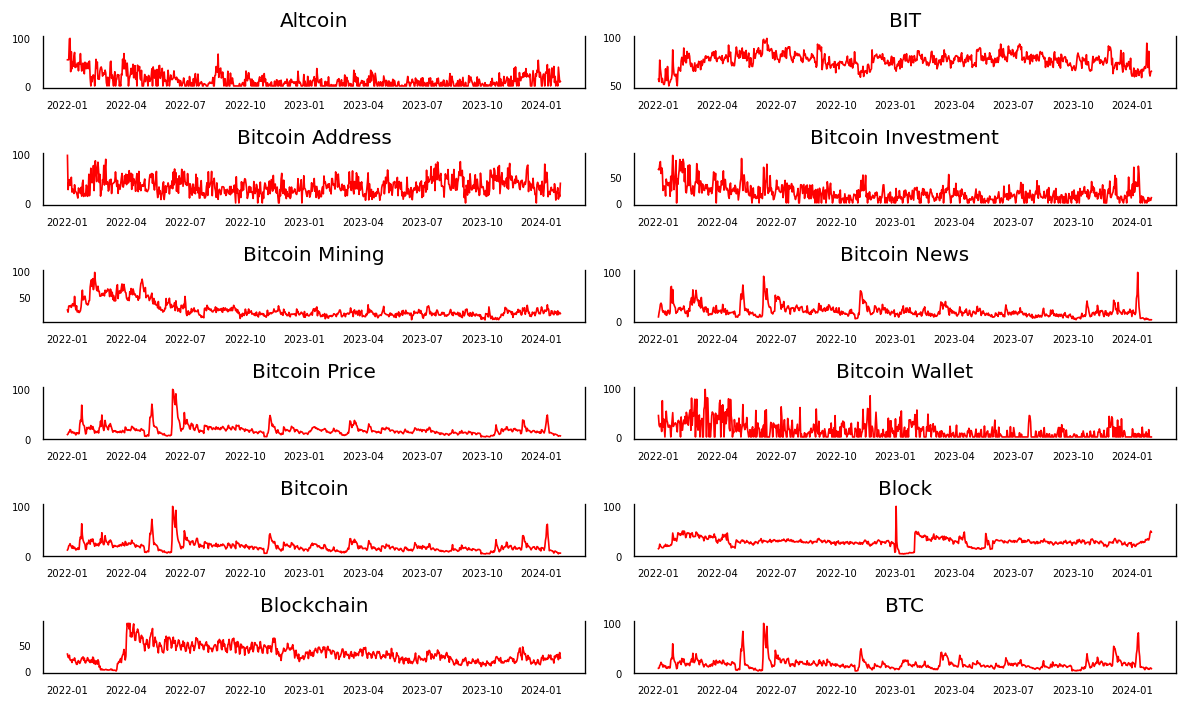

In [3]:
# Plot
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Cointegration Test

In [4]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name            ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col, 15), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name            ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Altcoin         ::  2202.3    > nan       =>   False
BIT             ::  1995.63   > nan       =>   False
Bitcoin Address ::  1796.34   > nan       =>   False
Bitcoin Investment ::  1621.91   > nan       =>   False
Bitcoin Mining  ::  1459.61   > nan       =>   False
Bitcoin News    ::  1308.65   > nan       =>   False
Bitcoin Price   ::  1168.65   > nan       =>   False
Bitcoin Wallet  ::  1041.64   > nan       =>   False
Bitcoin         ::  929.69    > nan       =>   False
Block           ::  825.04    > nan       =>   False
Blockchain      ::  725.96    > nan       =>   False
BTC             ::  633.86    > nan       =>   False
Crypto          ::  555.04    > nan       =>   False
Cryptocurrency  ::  482.82    > nan       =>   False
Cryptography    ::  415.25    > nan       =>   False
DAPP            ::  352.62    > 311.1288  =>   True
DeFi            ::  295.58    > 263.2603  =>   True


/var/folders/4h/_njzjctj4c7_9q_c0xpcph4c0000gn/T/ipykernel_44462/1029603928.py:5: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  out = coint_johansen(df,-1,5)


# Split the Series into Training and Testing Data

In [5]:
nobs = 16
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(744, 27)
(16, 27)


# Check for Stationarity and Make the Time Series Stationary

In [6]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
        return True
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        return False
# ADF Test on each column
stationary = True
for name, column in df_train.items():
    temp = adfuller_test(column, name=column.name)
    stationary = stationary and temp
    print('\n')
if stationary:
    print('Proceed')
else:
    print('Need differencing')

    Augmented Dickey-Fuller Test on "Altcoin" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4534
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BIT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7844
 No. Lags Chosen       = 7
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Bitcoin Address" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significa

## 1st difference

In [7]:
df_differenced = df_train.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
stationary = True
for name, column in df_differenced.items():
    temp = adfuller_test(column, name=column.name)
    stationary = stationary and temp
    print('\n')
if stationary:
    print('Proceed')
else:
    print('Need differencing')

    Augmented Dickey-Fuller Test on "Altcoin" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.0597
 No. Lags Chosen       = 19
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BIT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.5817
 No. Lags Chosen       = 9
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Bitcoin Address" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance 

# Select the Order (P) of VAR model

In [8]:
model = VAR(df_differenced)
x = model.select_order(maxlags=25)
x.summary()

/Users/lichang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,113.2,113.3*,1.390e+49,113.2
1,110.2,115.0,7.386e+47,112.1
2,109.6,119.1,4.177e+47,113.3
3,109.8,123.9,4.797e+47,115.2
4,110.1,128.9,6.953e+47,117.3
5,110.0,133.4,6.956e+47,119.1
6,110.5,138.6,1.218e+48,121.3
7,110.7,143.4,1.657e+48,123.3
8,110.8,148.2,2.267e+48,125.2
9,110.9,152.9,3.140e+48,127.1


# Train the VAR Model of Selected Order(p)

In [9]:
model_fitted = model.fit(25)
# model_fitted.summary()

# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [10]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Altcoin : 1.95
BIT : 1.7
Bitcoin Address : 1.7
Bitcoin Investment : 1.9
Bitcoin Mining : 2.0
Bitcoin News : 2.1
Bitcoin Price : 1.97
Bitcoin Wallet : 1.77
Bitcoin : 1.92
Block : 2.18
Blockchain : 2.0
BTC : 1.94
Crypto : 1.97
Cryptocurrency : 1.88
Cryptography : 1.83
DAPP : 2.04
DeFi : 1.95
Digital Currency : 1.94
Ethereum : 1.95
Fiat money : 1.85
Fork : 1.9
Hash Rate : 1.88
ICO : 1.74
P2P : 1.66
Private Key : 1.64
Stablecoin : 1.94
Price : 1.57


# Forecast VAR model using statsmodels

In [11]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

25


array([[-1.58400000e+01, -3.36000000e+00,  1.86000000e+00,
        -4.44000000e+00,  1.24000000e+00,  3.85000000e+00,
        -2.80000000e-01, -9.92000000e+00,  0.00000000e+00,
        -4.93000000e+00, -4.16000000e+00, -3.50000000e-01,
        -3.15000000e+00, -2.64000000e+00, -3.68000000e+00,
        -2.04000000e+00,  6.16000000e+00,  6.30000000e-01,
         2.88000000e+00,  6.30000000e-01, -2.94000000e+00,
         3.30000000e+00, -2.88000000e+00, -1.31400000e+01,
        -2.52000000e+01, -9.00000000e-01,  2.16902344e+02],
       [ 0.00000000e+00, -8.40000000e-01, -1.42600000e+01,
         1.11000000e+00, -6.51000000e+00, -1.05000000e+00,
        -2.52000000e+00,  0.00000000e+00, -3.60000000e+00,
        -5.80000000e-01, -2.24000000e+00, -4.55000000e+00,
         7.00000000e-01,  0.00000000e+00, -8.28000000e+00,
        -1.02000000e+00, -6.16000000e+00, -3.43000000e+00,
        -3.60000000e+00, -4.83000000e+00,  2.94000000e+00,
         3.00000000e-01, -1.51200000e+01, -3.65000000e+

In [12]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,Altcoin_1d,BIT_1d,Bitcoin Address_1d,Bitcoin Investment_1d,Bitcoin Mining_1d,Bitcoin News_1d,Bitcoin Price_1d,Bitcoin Wallet_1d,Bitcoin_1d,Block_1d,...,Digital Currency_1d,Ethereum_1d,Fiat money_1d,Fork_1d,Hash Rate_1d,ICO_1d,P2P_1d,Private Key_1d,Stablecoin_1d,Price_1d
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-15,-18.529126,32.009086,97.522786,-61.595075,26.349132,-57.409927,-19.724643,206.337011,-35.065479,-44.745286,...,-29.871091,-6.121990,-50.043547,-22.820610,18.898401,-93.587842,-6.682903,-46.692349,0.950676,663.667664
2024-01-16,45.921238,-22.136753,-46.329442,-19.819843,-5.215585,32.925814,-2.150496,-113.238082,-1.741510,44.164878,...,-1.160605,-10.457131,1.560431,-5.021560,-2.054292,-2.481409,75.513522,29.701168,-5.439455,-1750.721602
2024-01-17,-39.608341,-4.464656,-5.565066,63.774321,-0.159251,6.786321,15.341181,-57.719208,31.059830,-1.800386,...,-16.824252,27.896234,46.800141,-3.970291,-20.795546,49.377417,-43.465160,3.107965,-9.622164,3543.172993
2024-01-18,6.158764,16.441048,-74.675886,35.833305,-9.994698,13.436176,-0.029436,-23.922150,-3.551711,2.455579,...,19.126100,15.802313,8.110431,41.187487,-4.577540,42.596140,-32.456405,-98.621270,-15.052827,982.967876
2024-01-19,-59.093870,0.038358,63.518961,9.404935,-1.334574,1.129097,-11.924002,-44.357694,-0.557633,49.093381,...,10.486512,-35.132721,22.740015,0.720689,21.713773,-31.074386,19.998513,10.744203,10.794903,4755.143079
2024-01-20,0.613096,11.488497,-12.524613,-1.560223,8.786683,-34.553433,-12.530297,43.426290,-16.599749,4.158958,...,-3.001844,-34.693693,-23.401643,27.419672,-5.791522,38.968663,-42.564923,71.495333,-2.232861,-4252.846155
2024-01-21,-14.355448,2.626261,-22.893273,-32.082032,-28.346676,23.463483,16.564968,-34.434863,14.642533,1.099706,...,26.751016,-1.115149,3.003599,-1.123442,-4.216560,45.190377,-18.701061,3.239574,23.350010,219.187941
2024-01-22,44.595480,-4.190396,45.275129,13.240159,-14.647689,1.743712,-0.129517,32.702116,12.148797,3.365155,...,-8.905159,3.340560,-17.289824,-31.089643,-25.449354,-43.149446,-10.434449,77.678470,3.303236,-3978.434679
2024-01-23,50.145899,25.079841,-58.516721,23.698460,0.586032,42.121575,19.599184,-75.028507,5.467305,41.766606,...,5.797725,21.669393,-4.482335,-2.401461,37.586504,83.601008,97.725598,27.561711,10.375807,-1374.439398


# Invert the transformation to get the real forecast

In [13]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [14]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
cols = [s + '_forecast' for s in df.columns.values.tolist()]
df_results.loc[:, cols]

,Altcoin_forecast,BIT_forecast,Bitcoin Address_forecast,Bitcoin Investment_forecast,Bitcoin Mining_forecast,Bitcoin News_forecast,Bitcoin Price_forecast,Bitcoin Wallet_forecast,Bitcoin_forecast,Block_forecast,...,Digital Currency_forecast,Ethereum_forecast,Fiat money_forecast,Fork_forecast,Hash Rate_forecast,ICO_forecast,P2P_forecast,Private Key_forecast,Stablecoin_forecast,Price_forecast
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-15,-2.249126,98.009086,114.882786,-53.015075,42.159132,-52.159927,-6.964643,206.337011,-23.185479,-15.945286,...,-28.671091,6.298010,-40.863547,21.679390,23.858401,-53.027842,33.317097,-2.142349,6.150676,42459.937195
2024-01-16,43.672113,75.872333,68.553344,-72.834918,36.943547,-19.234113,-9.115139,93.098929,-24.926989,28.219592,...,-29.831696,-4.159121,-39.303116,16.657830,21.804109,-55.509251,108.830620,27.558819,0.711221,40709.215594
2024-01-17,4.063771,71.407678,62.988278,-9.060596,36.784296,-12.447793,6.226042,35.379721,6.132841,26.419207,...,-46.655949,23.737113,7.497026,12.687539,1.008563,-6.131834,65.365460,30.666784,-8.910943,44252.388587
2024-01-18,10.222535,87.848726,-11.687608,26.772709,26.789598,0.988383,6.196605,11.457571,2.581130,28.874786,...,-27.529849,39.539426,15.607457,53.875025,-3.568977,36.464306,32.909055,-67.954486,-23.963771,45235.356463
2024-01-19,-48.871335,87.887083,51.831353,36.177644,25.455025,2.117480,-5.727397,-32.900124,2.023497,77.968167,...,-17.043337,4.406705,38.347472,54.595714,18.144796,5.389920,52.907567,-57.210283,-13.168868,49990.499542
2024-01-20,-48.258239,99.375581,39.306741,34.617421,34.241708,-32.435953,-18.257694,10.526166,-14.576252,82.127125,...,-20.045181,-30.286989,14.945829,82.015386,12.353275,44.358583,10.342644,14.285050,-15.401729,45737.653387
2024-01-21,-62.613686,102.001842,16.413468,2.535389,5.895032,-8.972470,-1.692726,-23.908697,0.066282,83.226832,...,6.705835,-31.402138,17.949428,80.891944,8.136714,89.548960,-8.358416,17.524624,7.948281,45956.841328
2024-01-22,-18.018206,97.811446,61.688596,15.775548,-8.752657,-7.228758,-1.822242,8.793419,12.215078,86.591987,...,-2.199324,-28.061579,0.659604,49.802301,-17.312639,46.399515,-18.792865,95.203094,11.251517,41978.406649
2024-01-23,32.127693,122.891287,3.171875,39.474008,-8.166626,34.892818,17.776942,-66.235088,17.682383,128.358593,...,3.598401,-6.392186,-3.822730,47.400840,20.273864,130.000522,78.932733,122.764805,21.627324,40603.967251


# Plot of Forecast vs Actuals

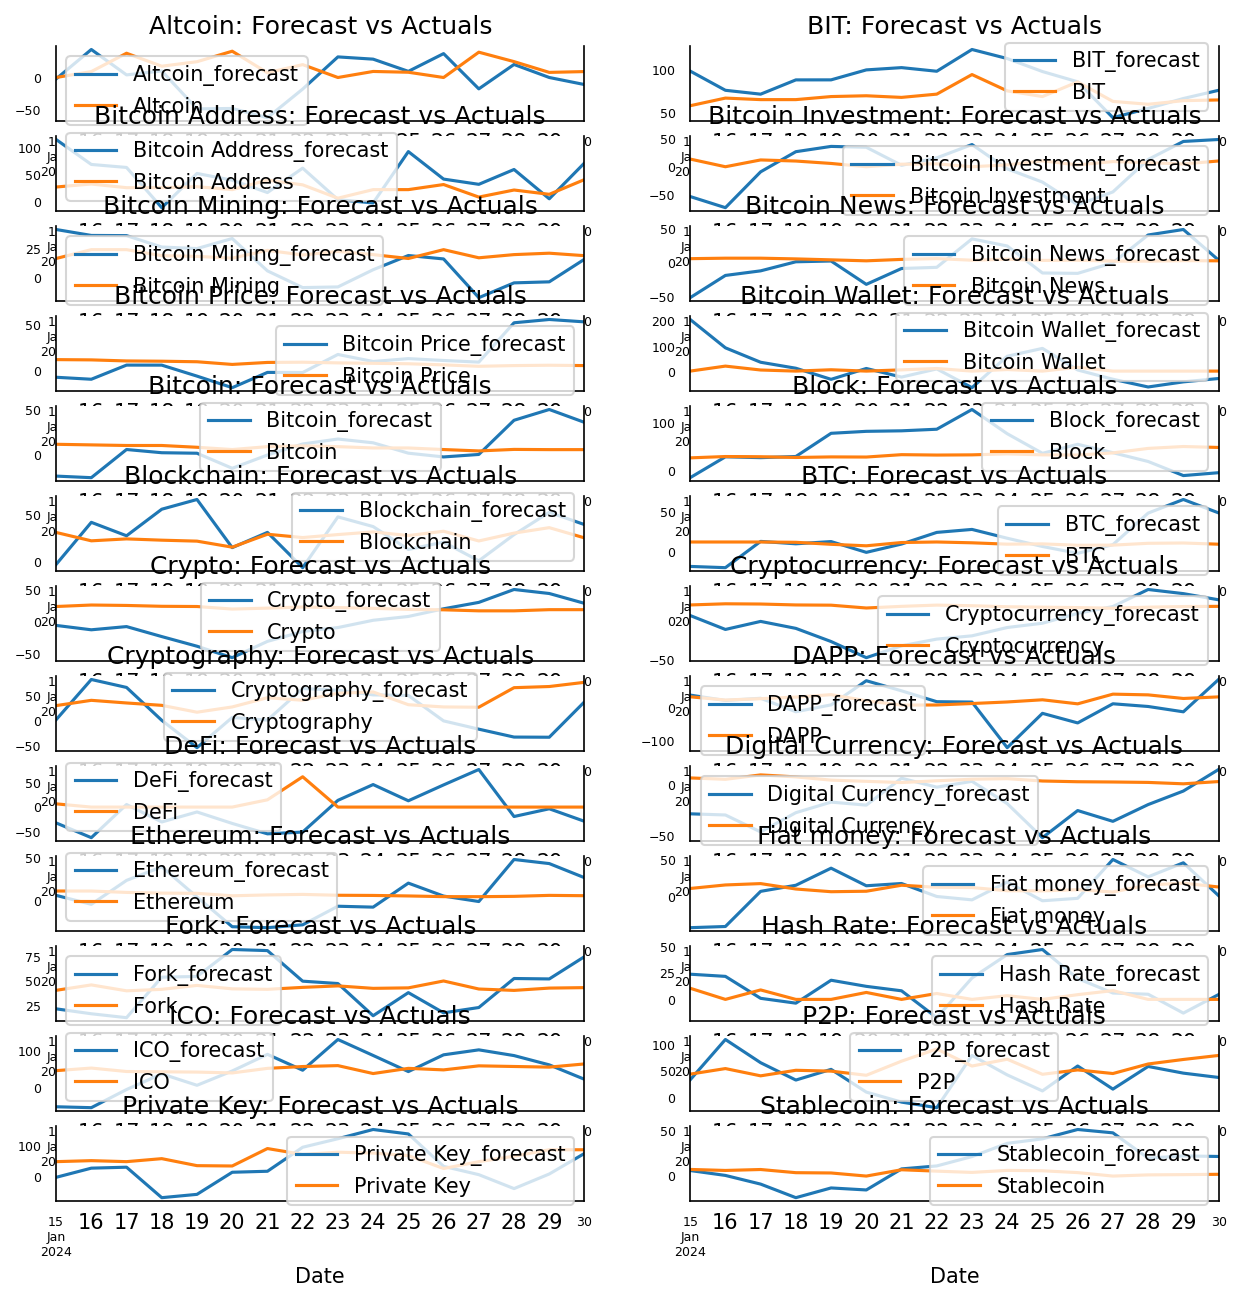

In [18]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

#plt.tight_layout();

# Evaluate the Forecasts

In [16]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'me':me, 'mae': mae, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [22]:
for col in df.columns.values.tolist():
    print('\nForecast Accuracy of: ' + col)
    accuracy_prod = forecast_accuracy(df_results[col + '_forecast'].values, df_test[col].values)
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))


Forecast Accuracy of: Altcoin
me :  -17.4823
mae :  33.029
rmse :  42.3228
corr :  -0.4284
minmax :  inf

Forecast Accuracy of: BIT
me :  17.0514
mae :  19.9992
rmse :  23.6176
corr :  0.5992
minmax :  0.214

Forecast Accuracy of: Bitcoin Address
me :  19.5272
mae :  31.5319
rmse :  37.9413
corr :  0.3475
minmax :  0.6515

Forecast Accuracy of: Bitcoin Investment
me :  -7.3078
mae :  34.2661
rmse :  40.9355
corr :  -0.1031
minmax :  inf

Forecast Accuracy of: Bitcoin Mining
me :  -6.4119
mae :  16.9619
rmse :  19.6582
corr :  -0.0231
minmax :  0.7238

Forecast Accuracy of: Bitcoin News
me :  -4.558
mae :  21.6722
rmse :  26.9956
corr :  -0.4062
minmax :  3.477

Forecast Accuracy of: Bitcoin Price
me :  3.6108
mae :  17.5729
rmse :  23.7125
corr :  -0.6255
minmax :  1.0284

Forecast Accuracy of: Bitcoin Wallet
me :  10.1412
mae :  49.4206
rmse :  68.388
corr :  0.1985
minmax :  inf

Forecast Accuracy of: Bitcoin
me :  -0.9535
mae :  16.2764
rmse :  21.3439
corr :  -0.4852
minmax :  1.1

/var/folders/4h/_njzjctj4c7_9q_c0xpcph4c0000gn/T/ipykernel_44462/3252965265.py:11: RuntimeWarning: divide by zero encountered in divide
  minmax = 1 - np.mean(mins/maxs)             # minmax
